# Neste notebook vamos simular a medição de um SLIT

In [1]:
# importar as bibliotecas necessárias
import numpy as np # arrays
import matplotlib.pyplot as plt # plots
plt.rcParams.update({'font.size': 14})
import IPython.display as ipd # to play signals
import sounddevice as sd
import soundfile as sf
# Os próximos módulos são usados pra criar nosso SLIT
from scipy.signal import butter, lfilter, freqz, chirp, impulse

# 0. Vamos criar um SLIT

Primeiro vamos criar um SLIT. Nós vamos conhecer a resposta desse SLIT perfeitamente. Mas na prática isso não ocorre e o que desejamos é medir a $h(t)$ do SLIT.

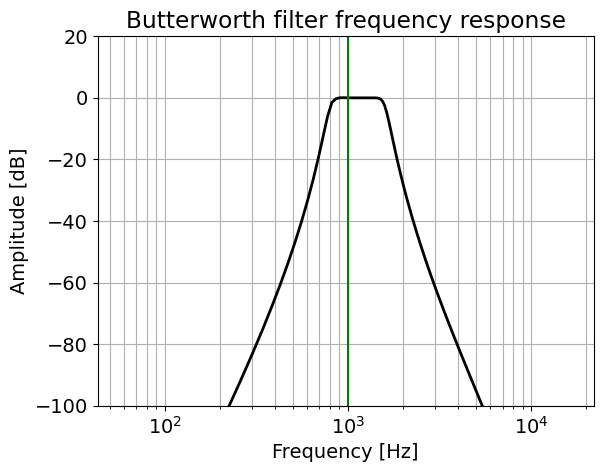

In [2]:
# Variáveis do filtro
order = 6
fs = 44100       # sample rate, Hz
cutoff = 1000    # desired cutoff frequency of the filter, Hz
nyq = 0.5 * fs
normal_cutoff = cutoff / nyq
#b, a = butter(order, 2*cutoff/fs, btype='low', analog=False)
b, a = butter(order, [2*800/fs, 2*1600/fs], btype='band', analog=False)
w, H_ref = freqz(b, a)


plt.semilogx(fs*w/(2*np.pi), 20 * np.log10(abs(H_ref)), 'k', linewidth = 2)
plt.title('Butterworth filter frequency response')
plt.xlabel('Frequency [Hz]')
plt.ylabel('Amplitude [dB]')
plt.margins(0, 0.1)
plt.grid(which='both', axis='both')
plt.axvline(cutoff, color='green') # cutoff frequency
plt.ylim((-100, 20))
plt.show()

# 1. Vamos criar um sweep, $x(t)$

Geramos um sinal $x(t)$ cujo espectro é conhecido (e.g. ruído branco, ou sweep). Este sinal pode ser gravado em um canal do analisador ou mesmo salvo na memória, caso seja determinístico;

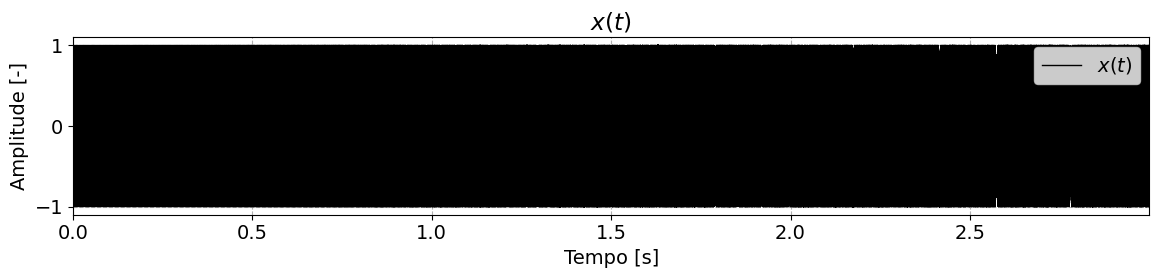

In [20]:
# x(t)
time = np.arange(0, 3, 1/fs)
xt = chirp(time, 300, time[-1], 20000, method = 'logarithmic')

plt.figure(figsize=(12,3))
plt.title(r'$x(t)$')
plt.plot(time, xt, '-k', linewidth = 1, label = r'$x(t)$')
plt.legend(loc = 'upper right')
plt.grid(linestyle = '--', which='both')
plt.xlabel('Tempo [s]')
plt.ylabel('Amplitude [-]')
plt.xlim((0, time[-1]))
plt.tight_layout()
plt.show()

# play x(t)
ipd.Audio(xt, rate=fs) # load a NumPy array

# 2.  Passar pelo sistema, gerando nosso sinal de saída $y(t)$

Passamos $x(t)$ pelo SLIT e gravamos o sinal de saída $y(t)$. É comum que nosso sinal de saída esteja contaminado por ruído

\begin{equation}
y(t) = x(t) * h(t) + n(t)
\tag{1}
\end{equation}
em que $n(t)$ vai ser um ruído aleatório com distribuição Normal de probabilidade, cujo valor médio é 0 (zero) e a variância indica o valor RMS deste ruído.

SNR relative to x(t) is 40.0 [dB]


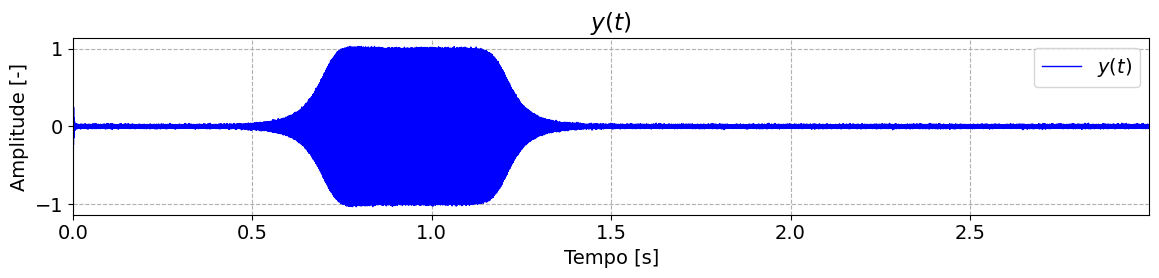

In [21]:
# y(t) - filtramos x(t) com o filtro anteriormente criado e adicionamos um pouco de ruído (típico de uma medição)
std = 0.01
print('SNR relative to x(t) is {} [dB]'.format(-20*np.log10(std/np.amax(xt))))
yt = lfilter(b, a, xt) + np.random.normal(scale=std, size=len(time))


plt.figure(figsize=(12,3))
plt.title(r'$y(t)$')
plt.plot(time, yt, '-b', linewidth = 1, label = r'$y(t)$')
plt.legend(loc = 'upper right')
plt.grid(linestyle = '--', which='both')
plt.xlabel('Tempo [s]')
plt.ylabel('Amplitude [-]')
plt.xlim((0, time[-1]))
#plt.ylim((-0.1, 0.1))
plt.tight_layout()
plt.show()


# play y(t)
ipd.Audio(yt, rate=fs) # load a NumPy array

In [9]:
nh = 2*len(time)

# 3. Vamos recuperar a $H(\mathrm{j}\omega)$ do sistema

\begin{equation}
H(\mathrm{j} \omega)=\frac{Y(\mathrm{j} \omega)}{X(\mathrm{j} \omega)}
\tag{1}
\end{equation}

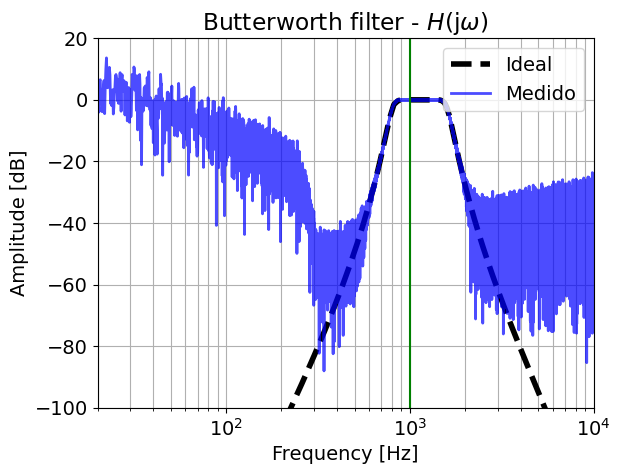

In [22]:
# Measured impulse response
Xjw = np.fft.fft(xt, nh)
Yjw = np.fft.fft(yt, nh)
Hjw = Yjw/Xjw
freq = np.linspace(0, (nh-1)*fs/nh, nh)

# Espectro
plt.semilogx(fs*w/(2*np.pi), 20 * np.log10(abs(H_ref)), '--k', linewidth = 4, label = 'Ideal')
plt.semilogx(freq, 20 * np.log10(abs(Hjw)), 'b', linewidth = 2, label = 'Medido', alpha = 0.7)
plt.legend(loc = 'upper right')
plt.title(r'Butterworth filter - $H(\mathrm{j}\omega)$')
plt.xlabel('Frequency [Hz]')
plt.ylabel('Amplitude [dB]')
plt.margins(0, 0.1)
plt.grid(which='both', axis='both')
plt.axvline(cutoff, color='green') # cutoff frequency
plt.ylim((-100, 20))
plt.xlim((20, 10000))
plt.show()



# 4. Finalmente, podemos obter a $h(t)$

Para isso usamos a transformada inversa de Fourier

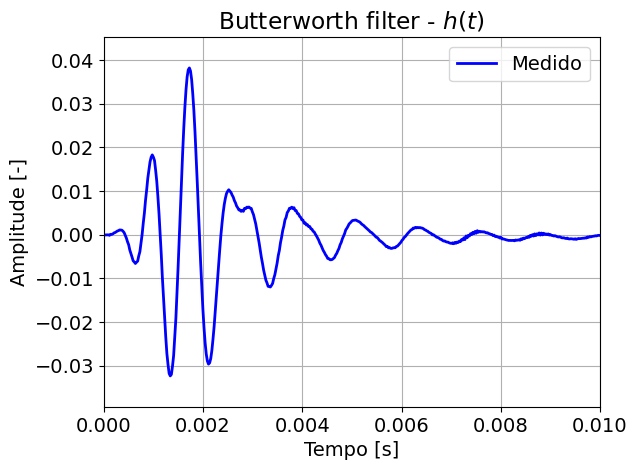

In [23]:
# Impulse response
ht = np.fft.ifft(Hjw)
timeh = np.linspace(0, (nh-1)/fs, nh)

plt.plot(timeh, np.real(ht), 'b', linewidth = 2, label = 'Medido')
plt.legend(loc = 'upper right')
plt.title(r'Butterworth filter - $h(t)$')
plt.xlabel('Tempo [s]')
plt.ylabel('Amplitude [-]')
plt.margins(0, 0.1)
plt.grid(which='both', axis='both')
#plt.ylim((-100, 20))
plt.xlim((0, 0.01))
plt.show()

# Podemos até escutar outro sinal que passa pelo SLIT. Note a redução nas altas frequências

In [19]:
xt_v, fs = sf.read('voice.wav')

yt_v = lfilter(b, a, xt_v)
# play y(t)
ipd.Audio(yt_v, rate=fs) # load a NumPy array

In [23]:
xt = np.random.randint(10, size=6)
ht = np.random.randint(10, size=6)
yt = np.convolve(xt, ht)

Xjw = np.fft.fft(xt, len(yt))
Yjw = np.fft.fft(yt, len(yt))
Hjw = Yjw/Xjw
htc = np.fft.ifft(Hjw)

In [26]:
yt

array([ 48, 118, 136, 120, 135, 199, 147,  62,  67,  57,  21])

In [24]:
print(ht)
print(htc)

[8 9 0 4 6 3]
[ 8.00000000e+00+0.j  9.00000000e+00+0.j  1.21115239e-15+0.j
  4.00000000e+00+0.j  6.00000000e+00+0.j  3.00000000e+00+0.j
  3.22973971e-16+0.j -6.45947942e-16+0.j -3.22973971e-16+0.j
 -8.07434927e-16+0.j  0.00000000e+00+0.j]
